# Pseudo-label MultiRC Dataset

The original BLEURT and MPNET models perform pretty well. They were trained on MultiRC.

However, our analysis of real student responses to CRIs shows that GPT pseudo-labels were better aligned with human scores.

While it would be nice to pseudo-label only authentic, representative data, we have a small number of real student responses that only cover a handful of subject areas.

In this notebook, we will pseudo-label a portion of the MultiRC dataset and mix it in with the pseudo-labeled authentic data. We will preserve the human scores as a test set.

In [26]:
import json
import io

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import jinja2
from dotenv import load_dotenv
from openai import OpenAI
import datasets

import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv("../.env")
client = OpenAI()

In [125]:
itell_df = pd.read_csv("../../data/itell-question-data-sampled.csv", index_col=0)

dataset_path = "../../data/multirc_contrastive_pairs.hf"
# dataset_path = "../../data/multirc-v

dd = datasets.DatasetDict.load_from_disk(dataset_path)

In [126]:
df = dd["train"].to_pandas().rename(columns={
    "passage": "chunk_text",
    "answer": "response",
})
df

,chunk_text,question,response,label,passage_id,question_id,answer_id
0,"The rally took place on October 17, the shooti...",When was Kayla Rolland shot?,February 17,0,1,26,168
1,"The rally took place on October 17, the shooti...",When was Kayla Rolland shot?,February 29,1,1,26,169
2,"The rally took place on October 17, the shooti...",When was Kayla Rolland shot?,October 29,0,1,26,170
3,"The rally took place on October 17, the shooti...",When was Kayla Rolland shot?,October 17,0,1,26,171
4,"The rally took place on October 17, the shooti...",When was Kayla Rolland shot?,February 17,0,1,26,172
...,...,...,...,...,...,...,...
21780,Women and minorities appear to be benefiting f...,What kind of discrimination was found and was ...,Suggestion was made to make an Equal Employmen...,1,81,942,4800
21781,Women and minorities appear to be benefiting f...,What kind of discrimination was found and was ...,Hardcore discrimination found. The government ...,1,81,942,4801
21782,Women and minorities appear to be benefiting f...,What kind of discrimination was found and was ...,Some unintentional discrimination in same geog...,0,81,942,4802
21783,Women and minorities appear to be benefiting f...,What kind of discrimination was found and was ...,Discrimination against women and minorities,1,81,942,4803


## Sample MultiRC

Sample MultiRC to match the word count distribution of our authentic iTELL data.
Many answers in MultiRC are short, but our authentic user data has answers longer than a few words pretty frequently.
We need to downsample anyway to keep costs low.

In [127]:
def calculate_word_count_proportions(reference_df, word_col='response', num_bins=10):
    """
    Calculate word count proportions from reference dataframe
    
    Parameters:
    reference_df: DataFrame containing the reference distribution
    word_col: Column name containing text data
    
    Returns:
    proportions: Series with proportions for each bin
    """
    word_count_col = f'{word_col}_word_count'
    reference_df[word_count_col] = (reference_df[word_col]
                                             .str.split()
                                             .str.len()
                                             .fillna(0))
    
    word_counts = reference_df[word_count_col]
    
    # Equal-width bins
    min_words = word_counts.min()
    max_words = word_counts.max()
    bins = np.percentile(word_counts, np.linspace(0, 100, num_bins+1))

    # Create bins and calculate proportions
    binned, bins = pd.cut(word_counts, bins=bins, include_lowest=True, duplicates='drop', retbins=True)
    print(bins)

    # Calculate counts and proportions
    bin_counts = binned.value_counts().sort_index()
    proportions = bin_counts / bin_counts.sum()
    
    print("Reference Distribution:")
    print("Bin Range\t\tCount\t\tProportion")
    print("-" * 50)
    for bin_range, count in bin_counts.items():
        prop = proportions[bin_range]
        print(f"{bin_range}\t\t{count}\t\t{prop:.4f}")

    proportions.index = pd.IntervalIndex.from_breaks(bins)
    
    return proportions

proportions = calculate_word_count_proportions(itell_df, word_col="response", num_bins=6)

[  1.   3.   6.   9.  14.  24. 184.]
Reference Distribution:
Bin Range		Count		Proportion
--------------------------------------------------
(0.999, 3.0]		304		0.2129
(3.0, 6.0]		233		0.1632
(6.0, 9.0]		218		0.1527
(9.0, 14.0]		217		0.1520
(14.0, 24.0]		231		0.1618
(24.0, 184.0]		225		0.1576


In [128]:
def apply_proportions_to_sample(source_df, target_proportions, total_sample_size,
                               word_col='response', random_state=42):
    """
    Apply calculated proportions to create stratified sample
    
    Parameters:
    source_df: DataFrame to sample from
    target_proportions: Series with target proportions (from calculate_proportions)
    total_sample_size: Total desired sample size
    word_col: Column name for word count in source_df
    """
    
    # Calculate word counts
    word_count_col = f'{word_col}_word_count'
    source_df[word_count_col] = (source_df[word_col]
                                             .str.split()
                                             .str.len()
                                             .fillna(0))

    # Get bins from target_proportions index
    bins = target_proportions.index
    
    # Bin the source data
    source_binned = pd.cut(source_df[word_count_col], bins=bins, include_lowest=True, right=False)
    
    # Sample from each bin according to target proportions
    sampled_dfs = []
    
    print("\nSampling Process:")
    print("Bin Range\tTarget\tTarget Count\tAvailable\tActual Sample")
    print("-" * 80)
    
    for bin_range, proportion in target_proportions.items():
        # Get data for this bin
        bin_mask = source_binned == bin_range
        bin_data = source_df[bin_mask]
        
        # Calculate target sample size for this bin
        target_count = int(total_sample_size * proportion)
        available_count = len(bin_data)
        actual_sample_size = min(target_count, available_count)
        
        print(f"{bin_range}\t{proportion:>7.1%}\t{target_count:>10}\t{available_count:>9}\t{actual_sample_size:>12}")
        
        if actual_sample_size > 0:
            bin_sample = bin_data.sample(n=actual_sample_size, random_state=random_state)
            sampled_dfs.append(bin_sample)
    
    if sampled_dfs:
        final_sample = pd.concat(sampled_dfs, ignore_index=True)
        print(f"\nFinal sample size: {len(final_sample)}")
        return final_sample
    else:
        print("Warning: No samples could be drawn!")
        return pd.DataFrame()

df_filtered = apply_proportions_to_sample(df, proportions, 5_000)


Sampling Process:
Bin Range	Target	Target Count	Available	Actual Sample
--------------------------------------------------------------------------------
(1.0, 3.0]	  21.3%	      1064	     7135	        1064
(3.0, 6.0]	  16.3%	       815	     4508	         815
(6.0, 9.0]	  15.3%	       763	     2071	         763
(9.0, 14.0]	  15.2%	       759	     1455	         759
(14.0, 24.0]	  16.2%	       808	      879	         808
(24.0, 184.0]	  15.8%	       787	      293	         293

Final sample size: 4502


## Test Prompt

In [136]:
environment = jinja2.Environment(loader=jinja2.FileSystemLoader("../prompts/"))
template = environment.get_template("response-score-without-reference-answer.jinja2")

print(template.render(df_filtered.sample(1).to_dict(orient="records")[0]))

You are an expert educational assessment evaluator. Your task is to score a student's short answer response based on a specific rubric.

SCORING RUBRIC:
Please score the student's response according to the following construct map. Examples for each level of response are provided in response to the following example question:

Example Question: "What are some examples of areas in which governments invest to facilitate capital deepening and technology?"

Level 4: Expert Reading
- Characteristics: Student demonstrates strong engagement with the text and full comprehension of the material.
- Response Quality: Demonstrates a command of the material and ability to manipulate concepts to form cohesive and detailed answers.
- Example of Level 4 Response: "Education, infrastructure, scientific research funding, and special economic zones are all examples of how governments invest to facilitate capital deepening and technology growth."

Level 3: Proficient Reading
- Characteristics: Student is e

## Test Model Response

In [134]:
sample = df_filtered.sample(1)
content = template.render(sample.to_dict(orient="records")[0])
print(content.split("1, 2, 3, or 4.")[1]) # Select the non-rubric elements of the prompt

response = client.chat.completions.create(
    model="gpt-5-2025-08-07",
    messages=[
        {
            "role": "user", 
            "content": content
        }
    ],
    response_format={  # {"score": "1"}
        "type": "json_schema",
        "json_schema": {
            "name": "cri_score_schema",
            "schema": {
                "type": "object",
                "properties": {
                    "score": {
                        "description": "A single digit from 1-4 representing the score of the student's response",
                        "type": "integer"
                    },
                    "additionalProperties": False
                }
            }
        }
    }
)

score_dict_string = response.choices[0].message.content
score_dict = json.loads(score_dict_string)
score = score_dict["score"]
print(f"GPT Score: {score}")



READING PASSAGE:
"""Federal agents on Tuesday raided a South Florida office of Dr. Salomon Melgen, an eye doctor whose past issues with authorities had already entangled Sen. Robert Menendez. With yellow crime tape strung up outside, men and women lugged box after box of materials from Melgen's West Palm Beach office into awaiting minivans. Both members of the federal Health and Human Services department and the Federal Bureau of Investigation took part in the search, which FBI Special Agent Michael Leverock said was the second at the same Melgen clinic -- the other coming last January. "As this is part of an ongoing investigation, (authorities have) no further comment/information at this time," said Leverock. That means no official details as to what authorities were looking for. Even if it has nothing to do with his record as a generous political donor, Tuesday's raid suggests Melgen's legal troubles and perhaps their negative impact on Menendez, the senior U.S. senator from New Je

# Score data

In [156]:
def format_request(
    custom_id, template_inputs, template, model_name="gpt-5-2025-08-07"
):
    return {
        "custom_id": custom_id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": model_name,
            "messages": [
                {"role": "user", "content": template.render(**template_inputs)}
            ],
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "cri_score_schema",
                    "schema": {
                        "type": "object",
                        "properties": {
                            "score": {
                                "description": "A single digit from 1-4 representing the score of the student's response",
                                "type": "integer"
                            },
                            "additionalProperties": False
                        }
                    }
                }
            }
        }
    }


batch_input = pd.DataFrame(
    [
        format_request(
            f"{row.question_id}_{row.answer_id}",
            {
                "chunk_text": row.chunk_text,
                "question": row.question,
                "response": row.response,
            },
            template,
        )
        for row in df_filtered.itertuples()
    ]
)

batch_input.to_json("../../data/filtered_multric_batch_input.jsonl", orient="records", lines=True)

display(batch_input)
print(batch_input.iloc[0]["body"]["messages"][0]["content"])

,custom_id,method,url,body
0,2248_11774,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
1,4269_22706,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
2,590_3087,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
3,1005_5247,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
4,3622_19247,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
...,...,...,...,...
4497,3860_20465,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
4498,1856_9680,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
4499,2589_13636,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."
4500,541_2777,POST,/v1/chat/completions,"{'model': 'gpt-5-2025-08-07', 'messages': [{'r..."


You are an expert educational assessment evaluator. Your task is to score a student's short answer response based on a specific rubric.

SCORING RUBRIC:
Please score the student's response according to the following construct map. Examples for each level of response are provided in response to the following example question:

Example Question: "What are some examples of areas in which governments invest to facilitate capital deepening and technology?"

Level 4: Expert Reading
- Characteristics: Student demonstrates strong engagement with the text and full comprehension of the material.
- Response Quality: Demonstrates a command of the material and ability to manipulate concepts to form cohesive and detailed answers.
- Example of Level 4 Response: "Education, infrastructure, scientific research funding, and special economic zones are all examples of how governments invest to facilitate capital deepening and technology growth."

Level 3: Proficient Reading
- Characteristics: Student is e

In [159]:
batch_input_file = client.files.create(
    file=open("../../data/filtered_multric_batch_input.jsonl", "rb"), purpose="batch"
)
batch_input_file_id = batch_input_file.id
batch_details = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": "Pseudo Score MultiRC 1"},
)
print(f"batch-id:\n{batch_details.id}\n")
print(batch_details)

batch-id:
batch_68a76232c18c81909e01cf696c400756

Batch(id='batch_68a76232c18c81909e01cf696c400756', completion_window='24h', created_at=1755800114, endpoint='/v1/chat/completions', input_file_id='file-P6M1CCq6wbJfxXj7KcXEsy', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1755886514, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'ASAP Scoring 1'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))


In [173]:
batch = client.batches.retrieve("batch_68a76232c18c81909e01cf696c400756")
print(batch)

Batch(id='batch_68a76232c18c81909e01cf696c400756', completion_window='24h', created_at=1755800114, endpoint='/v1/chat/completions', input_file_id='file-P6M1CCq6wbJfxXj7KcXEsy', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1755801523, error_file_id=None, errors=None, expired_at=None, expires_at=1755886514, failed_at=None, finalizing_at=1755801320, in_progress_at=1755800177, metadata={'description': 'ASAP Scoring 1'}, output_file_id='file-2JpHzzCmvsyaX7FgojxvHW', request_counts=BatchRequestCounts(completed=4502, failed=0, total=4502))


In [174]:
file_response = client.files.content("file-2JpHzzCmvsyaX7FgojxvHW")

In [175]:
results = pd.read_json(io.StringIO(file_response.text), lines=True)
results

,id,custom_id,response,error
0,batch_req_68a766e988a08190addbd5be274cb845,224811774,"{'status_code': 200, 'request_id': 'aed24bd10b...",NaN
1,batch_req_68a766e9e27c8190bad6efdaf2b733d9,426922706,"{'status_code': 200, 'request_id': 'eb14e4b324...",NaN
2,batch_req_68a766e9a2508190a3a3df0d57a20b0d,5903087,"{'status_code': 200, 'request_id': '905e78d7c0...",NaN
3,batch_req_68a766e9ab6c81908083d393cb25a82f,10055247,"{'status_code': 200, 'request_id': 'b4a44bd937...",NaN
4,batch_req_68a766e9860c8190b1177a099bdf6e44,362219247,"{'status_code': 200, 'request_id': 'b84672c407...",NaN
...,...,...,...,...
4497,batch_req_68a767b24a5c8190a376b502cfd9c53c,386020465,"{'status_code': 200, 'request_id': 'fdeb8a9bca...",NaN
4498,batch_req_68a767b265c08190991efa687cb86f58,18569680,"{'status_code': 200, 'request_id': '42c72419a6...",NaN
4499,batch_req_68a767b24fd88190989f83ff1ab67190,258913636,"{'status_code': 200, 'request_id': '31e408412a...",NaN
4500,batch_req_68a767b26ba88190a6d59901a71a9da9,5412777,"{'status_code': 200, 'request_id': '6d82979e72...",NaN


In [184]:
responses = results.apply(
    lambda x: x["response"]["body"]["choices"][0]["message"]["content"], axis=1
)

scores = [
    json.loads(resp)["score"]
    for resp in responses
]
print(scores[0])

1


In [185]:
df_filtered["gpt5_score"] = scores

df_filtered.sample(3)

,chunk_text,question,response,label,passage_id,question_id,answer_id,response_word_count,gpt5_score
1727,The Mummy 's Shroud is set in 1920 and tells t...,What happens to Kah-To-Bey after Prem takes hi...,He dies and is buried,1,250,2787,14699,5,3
2544,New Legitimacy: Organized crime was soon to ha...,What signified the ending of heavy mob influen...,The formation of the Nevada Gaming Control Board,1,106,1250,6388,8,2
2579,How can you describe your location? You might ...,Which way do lines of longitude run and what d...,Run horizontal and divide east and west,0,28,332,1798,7,2


In [186]:
df_filtered[["label", "gpt5_score"]].corr(method="spearman")

,label,gpt5_score
label,1.000000,0.779329
gpt5_score,0.779329,1.000000


In [187]:
df_filtered.to_csv("../../data/multirc-data-w-gpt5-scores.csv", index=False)

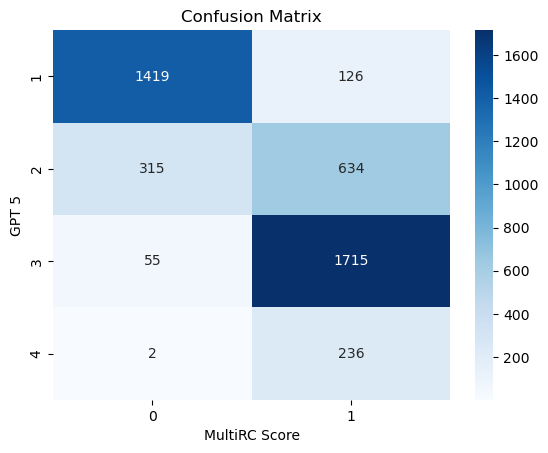

In [190]:
crosstab = pd.crosstab(
    df_filtered["gpt5_score"],
    df_filtered["label"],
)

sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0", "1"],
            yticklabels=["1", "2", "3", "4"])
plt.ylabel("GPT 5")
plt.xlabel("MultiRC Score")
plt.title("Confusion Matrix")
plt.show()

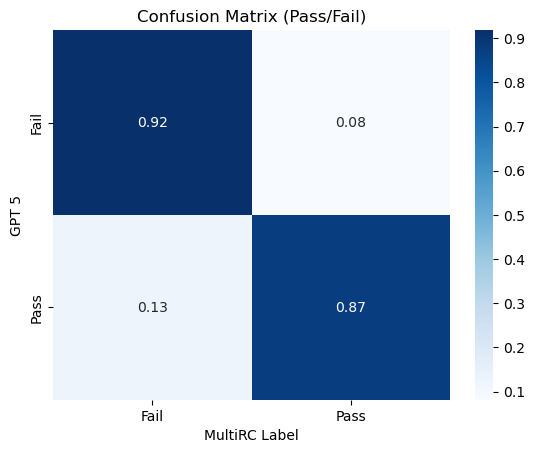

In [195]:
crosstab = pd.crosstab(
    df_filtered["gpt5_score"] > 1,
    df_filtered["label"] > 0,
    normalize="index",
)

sns.heatmap(crosstab, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=["Fail", "Pass"],
            yticklabels=["Fail", "Pass"])

plt.xlabel("MultiRC Label")
plt.ylabel("GPT 5")
plt.title("Confusion Matrix (Pass/Fail)")
plt.show()